#### load in modules

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

#### read in IATA global air traffic data

In [4]:
# load January 2020 data
air_traffic_202001 = pd.read_csv('./iata_data/country_flow_202001.csv')
air_traffic_202001 = air_traffic_202001.rename(columns={'Unnamed: 0': 'country'})
# load February 2020 data
air_traffic_202002 = pd.read_csv('./iata_data/country_flow_202002.csv')
air_traffic_202002 = air_traffic_202002.rename(columns={'Unnamed: 0': 'country'})
# load March 2020 data
air_traffic_202003 = pd.read_csv('./iata_data/country_flow_202003.csv')
air_traffic_202003 = air_traffic_202003.rename(columns={'Unnamed: 0': 'country'})

In [5]:
# get all countries and label them
countries = list(set(air_traffic_202001.country.unique().tolist() +
                     air_traffic_202002.country.unique().tolist() +
                     air_traffic_202003.country.unique().tolist()))
country_id = { country: i for i, country in enumerate(countries) }
id_country = { i: country for i, country in enumerate(countries) }

In [6]:
# transform data to long format and add country id (January 2020)
air_traffic_202001_long = air_traffic_202001.melt(id_vars=['country'], var_name='destination', value_name='flow')
air_traffic_202001_long = air_traffic_202001_long.rename(columns={'country': 'origin'})
air_traffic_202001_long['origin_id'] = air_traffic_202001_long.origin.apply(lambda x: country_id[x])
air_traffic_202001_long['destination_id'] = air_traffic_202001_long.destination.apply(lambda x: country_id[x])
# transform data to long format and add country id (February 2020)
air_traffic_202002_long = air_traffic_202002.melt(id_vars=['country'], var_name='destination', value_name='flow')
air_traffic_202002_long = air_traffic_202002_long.rename(columns={'country': 'origin'})
air_traffic_202002_long['origin_id'] = air_traffic_202002_long.origin.apply(lambda x: country_id[x])
air_traffic_202002_long['destination_id'] = air_traffic_202002_long.destination.apply(lambda x: country_id[x])
# transform data to long format and add country id (March 2020)
air_traffic_202003_long = air_traffic_202003.melt(id_vars=['country'], var_name='destination', value_name='flow')
air_traffic_202003_long = air_traffic_202003_long.rename(columns={'country': 'origin'})
air_traffic_202003_long['origin_id'] = air_traffic_202003_long.origin.apply(lambda x: country_id[x])
air_traffic_202003_long['destination_id'] = air_traffic_202003_long.destination.apply(lambda x: country_id[x])

In [21]:
# combine all data and calculate average flow (or sum of flow)
avg_air_traffic = pd.concat([air_traffic_202001_long, air_traffic_202002_long, air_traffic_202003_long])
avg_air_traffic = avg_air_traffic.groupby(['origin_id', 'origin', 'destination_id', 'destination']).agg({'flow': 'sum'}).reset_index()

#### symmetrise air traffic data and average

In [22]:
# remove self loops
avg_air_traffic = avg_air_traffic[avg_air_traffic.origin_id != avg_air_traffic.destination_id]
# label each row with a unique "a-b" string, where a and b are origin_id and destination_id sorted in ascending order
avg_air_traffic['edge_id'] = avg_air_traffic.apply(
    lambda x: '-'.join([str(d) for d in sorted([x.origin_id, x.destination_id])]), axis=1)

In [23]:
# now group by edge_id and sum the flow
avg_air_traffic = avg_air_traffic.groupby('edge_id').agg({'flow': 'sum'}).reset_index()

In [24]:
# split edge_id into origin_id and destination_id again and map them to their respective country
avg_air_traffic['origin_id'] = avg_air_traffic.edge_id.apply(lambda x: int(x.split('-')[0]))
avg_air_traffic['destination_id'] = avg_air_traffic.edge_id.apply(lambda x: int(x.split('-')[1]))
avg_air_traffic['origin'] = avg_air_traffic.origin_id.apply(lambda x: id_country[x])
avg_air_traffic['destination'] = avg_air_traffic.destination_id.apply(lambda x: id_country[x])

In [25]:
# remove edges with 0 flow
avg_air_traffic = avg_air_traffic[avg_air_traffic.flow > 0].copy()
# remove edges involving 'Unknown Country'
avg_air_traffic = avg_air_traffic[(avg_air_traffic.origin != 'Unknown Country') &
                                  (avg_air_traffic.destination != 'Unknown Country')].copy()
# remove edges involving 'Antarctica' and 'United States Minor Outlying Islands'
avg_air_traffic = avg_air_traffic[(avg_air_traffic.origin != 'Antarctica') &
                                  (avg_air_traffic.destination != 'Antarctica')].copy()
avg_air_traffic = avg_air_traffic[(avg_air_traffic.origin != 'United States Minor Outlying Islands') &
                                  (avg_air_traffic.destination != 'United States Minor Outlying Islands')].copy()

#### perform graph-thinning

In [78]:
# first edges in ascending order
avg_air_traffic_thinned = avg_air_traffic.sort_values('flow', ascending=True).reset_index(drop=True)

In [85]:
# iterate over edges and retain only x of edges with highest flow, while ensuring that the graph remains connected
thinning_threshold = 0.05
# construct graph to be thinned
air_traffic_thinned_graph = nx.from_pandas_edgelist(avg_air_traffic_thinned, source='origin', target='destination',
                                                    edge_attr='flow', create_using=nx.Graph)

# print number of nodes and edges in the graph before thinning
print('Number of nodes before graph-thinning:', len(air_traffic_thinned_graph.nodes))
print('Number of edges before graph-thinning:', len(air_traffic_thinned_graph.edges))

# thin graph (iterate over entries in italy_commute_MarMay_avg_sym_thinned)
edges_to_remove = len(avg_air_traffic_thinned) * (1 - thinning_threshold)
edges_removed = 0
for edge in avg_air_traffic_thinned.iterrows():
    if edges_removed >= edges_to_remove:
        break
    # check that the graph would main connected if the edge was removed
    air_traffic_thinned_graph.remove_edge(edge[1].origin, edge[1].destination)
    if not nx.is_connected(air_traffic_thinned_graph):
        # add the edge back
        air_traffic_thinned_graph.add_edge(edge[1].origin, edge[1].destination)
        continue
    edges_removed += 1

# print number of nodes and edges in the graph after thinning
print('Number of nodes after graph-thinning:', len(air_traffic_thinned_graph.nodes))
print('Number of edges after graph-thinning:', len(air_traffic_thinned_graph.edges))
# check that the graph is connected
print('Is the graph connected?', nx.is_connected(air_traffic_thinned_graph))

Number of nodes before graph-thinning: 224
Number of edges before graph-thinning: 13327
Number of nodes after graph-thinning: 224
Number of edges after graph-thinning: 666
Is the graph connected? True


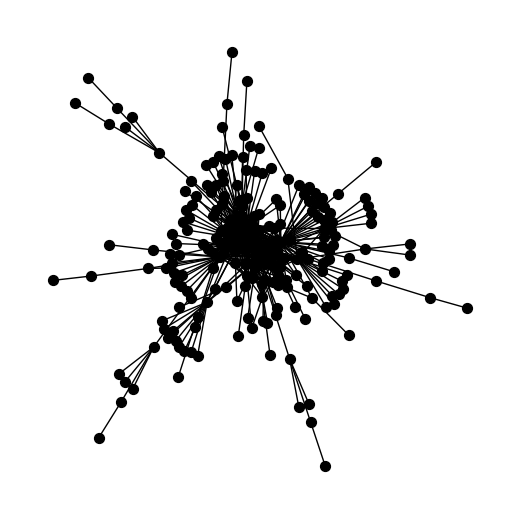

In [104]:
# draw the thinned graph
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(air_traffic_thinned_graph)
nx.draw(air_traffic_thinned_graph, pos, node_size=50, node_color='k', with_labels=False)
plt.show()

#### plot thinned graph on a map

In [87]:
# load world shape file
world_shp = gpd.read_file('./shape_files/world-administrative-boundaries.shp')

In [88]:
# dissolve to get world borders
world_boundary_shp = world_shp.dissolve(by='continent')

In [89]:
# country name mapping
country_names_map = {
    "The former Yugoslav Republic of Macedonia": "Macedonia",
    "Hong Kong": "Hong Kong (SAR), China",
    "Timor-Leste": "East Timor",
    "Iran (Islamic Republic of)": "Iran",
    "Falkland Islands (Malvinas)": "Falkland Islands",
    "CÃ´te d'Ivoire": "Ivory Coast (Cote d'Ivoire)",
    "Libyan Arab Jamahiriya": "Libya",
    "Grenada": "Grenada and South Grenadines",
    "Saint Vincent and the Grenadines": "Saint Vincent and Grenadines",
    "Moldova, Republic of": "Moldova",
    "Micronesia (Federated States of)": "Micronesia",
    "United Republic of Tanzania": "Tanzania",
    "Republic of Korea": "South Korea",
    "Lao People's Democratic Republic": "Laos",
    "U.K. of Great Britain and Northern Ireland": "United Kingdom",
    "United States of America": "United States",
    "Samoa": "Western Samoa",
    "Bosnia & Herzegovina": "Bosnia and Herzegovina",
    "Guinea-Bissau": "Guinea Bissau",
    "Antigua & Barbuda": "Antigua and Barbuda",
    "Macao": "Macau (SAR), China",
    "Taiwan": "Chinese Taipei",
    "Democratic People's Republic of Korea": "North Korea",
    "Syrian Arab Republic": "Syria",
    "Gaza Strip": "Palestinian Territory"
}
world_renamed_shp = world_shp.copy()
world_renamed_shp['new_name'] = world_renamed_shp.name.apply(lambda x: country_names_map[x] if x in country_names_map else x)

In [90]:
# extract country centroids
country_centroids = {}
for country in world_renamed_shp.new_name.unique():
    centroid = world_renamed_shp[world_renamed_shp.new_name == country].geometry.centroid
    country_centroids[str(country)] = (centroid.x.values[0], centroid.y.values[0])

/var/folders/q9/0h40wkyj4s79vh8zt8z0yssm0000gp/T/ipykernel_27015/909045260.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = world_renamed_shp[world_renamed_shp.new_name == country].geometry.centroid
/var/folders/q9/0h40wkyj4s79vh8zt8z0yssm0000gp/T/ipykernel_27015/909045260.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = world_renamed_shp[world_renamed_shp.new_name == country].geometry.centroid
/var/folders/q9/0h40wkyj4s79vh8zt8z0yssm0000gp/T/ipykernel_27015/909045260.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = world_renamed

In [91]:
# manually add coordinates to countries with missing centroids
country_centroids['Bonaire, Saint Eustatius & Saba'] = (-68.262383, 12.168371)
country_centroids['Curacao'] = (-68.972, 12.1955)
country_centroids['Saint Barthelemy'] = (-63.0431, 17.8988)
country_centroids['Saint Helena'] = (-5.717, -15.967)
country_centroids['Saint Martin'] = (-63.057, 18.0858)
country_centroids['Saint Pierre and Miquelon'] = (-56.3159, 46.8852)
country_centroids['Sint Maarten'] = (-63.057, 18.0858)
country_centroids['Wallis and Futuna Islands'] = (-176.2, -13.3)
country_centroids['Antarctica'] = (0, 0)

In [92]:
# check if there are any countries in the graph that are not in the world shapefile
set(avg_air_traffic.origin.unique().tolist() + avg_air_traffic.destination.unique().tolist()) - set(country_centroids.keys())

set()

In [93]:
# map country names to node ids
thinned_graph_id_centroids = { i: country_centroids[node] for i, node in enumerate(air_traffic_thinned_graph.nodes) }
# relabel nodes
thinned_graph_country_node_mapping = { node: i for i, node in enumerate(air_traffic_thinned_graph.nodes) }
thinned_graph_node_country_mapping = { i: node for i, node in enumerate(air_traffic_thinned_graph.nodes) }
air_traffic_thinned_graph = nx.relabel_nodes(air_traffic_thinned_graph, thinned_graph_country_node_mapping)

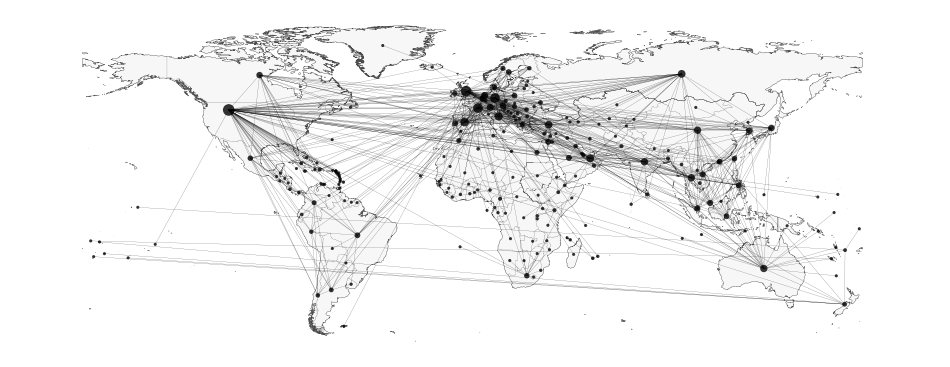

In [99]:
# draw network on map
fig, ax = plt.subplots(figsize=(12, 12))
world_shp.plot(ax=ax, color='#F7F7F7', edgecolor='#484848', linewidth=0.1, alpha=1)
world_boundary_shp.plot(ax=ax, color='none', edgecolor='#484848', linewidth=0.2, alpha=1)

# extract edges from graph
edges = air_traffic_thinned_graph.edges

# specify node radius according to degree
degree = dict(air_traffic_thinned_graph.degree)
max_degree = max(degree.values())
min_degree = min(degree.values())
# linear scale
node_sizes = [5 + (70 - 5) * (degree[node] - min_degree) / (max_degree - min_degree) for node in air_traffic_thinned_graph.nodes]

# draw graph
nx.draw_networkx_nodes(air_traffic_thinned_graph, thinned_graph_id_centroids,
                       node_size=node_sizes, linewidths=0, node_color='k', edgecolors='w', alpha=0.8, ax=ax)
nx.draw_networkx_edges(air_traffic_thinned_graph, thinned_graph_id_centroids,
                       width=0.1, alpha=1, edge_color='black', ax=ax)

# remove border
plt.gca().set_axis_off()

plt.show()

In [100]:
# export thinned graph as adjlist
nx.write_adjlist(air_traffic_thinned_graph, 'iata-thinning-threshold-0.05.adjlist')